# Test 4: Optimize a Blend with All The Constraints


As previously, we **discretize** the blending function $w(i)$ as a sequence of samples. Each sample is the value of $w(i)$ and its first 5 derivatives.

That is, our decision variables at each sample is:

$$
\begin{align}
\mathbf{d}_i = & \left(
\begin{array}{r}
w_i &
\frac{dw_i}{dt} & 
\frac{d^2w_i}{dt^2} & 
\frac{d^3w_i}{dt^3} &
\frac{d^4w_i}{dt^4} &
\frac{d^5w_i}{dt^5} &
\end{array}
\right) \\
= & \left(
\begin{array}{r}
w_i &
\dot{w}_i & 
\ddot{w}_i & 
\dddot{w}_i & 
\ddddot{w}_i & 
v_i & 
\end{array}
\right)
\end{align}
$$

For convenience, we will define $w(i)$ and only its first 4 derivatives as:

$$
\mathbf{s}_i = \left(
\begin{array}{r}
w_i &
\dot{w}_i & 
\ddot{w}_i & 
\dddot{w}_i & 
\ddddot{w}_i & 
\end{array}
\right)
$$

So our decision variables are the matrix:

$$
\mathbf{D} = \left[
\begin{array}{c}
d_0\\
\cdots\\
d_n
\end{array}
\right]
$$

We write down the following minimization problem:

$$
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & \lambda_p\Sigma_i(w_i - 0.5)^2dt + \lambda_s\Sigma_i(\ddddot{w_i})^2dt\\
& \text{subject to}
& & 0 \leq w_i \leq 1 , \; i = 1, \ldots, n.\\
&&& v_{min} \leq v \leq v_{max} \\
&&& \mathbf{s}_{i+1} = \mathbf{s}_{i} + (\mathbf{M}\mathbf{s}_i + \mathbf{N}v)dt , \; i = 1, \ldots, n. \\
&&& \text{Let } \sigma_i = w_i\cdot\sigma_A(i) + (1 - w_i)\cdot\sigma_B(i) \\
&&& \; \|\sigma_i - A\| \geq d_{a} , \; i = 1, \ldots, n. \\
&&& \; \|\sigma_i - B\| \geq d_{b} , \; i = 1, \ldots, n. \\
\end{aligned}
\end{equation*}
$$

Notice that the two norm-constraints are **non-convex constraints** from obstacles.  Notice also that we now have additional "parameters": the optimizer depends on the values of $A$, $B$, $\sigma_A(i)$, $\sigma_B(i)$

We rewrite our constraints so that they are all equality to a scalar value. That is:

$$
\mathbf{s}_{i} + (\mathbf{M}\mathbf{s}_i + \mathbf{N}v)dt - \mathbf{s}_{i+1} = 0
$$

$$
\|\sigma_i - A\| - d_{a} \geq 0\\
$$

$$
\|\sigma_i - B\| - d_{b} \geq 0\\
$$
where

$$
\begin{array}{r}
\mathbf{M} = \begin{bmatrix}
0&1&0&0&0\\
0&0&1&0&0\\
0&0&0&1&0\\
0&0&0&0&1\\
0&0&0&0&0\\
\end{bmatrix} & 
\mathbf{N} = \begin{bmatrix}
0\\
0\\
0\\
0\\
1\\
\end{bmatrix}
\end{array}
$$

**Notice we now have the following parameters**

* $\lambda_p$ and $\lambda_s$, the relative preference to minimize position or snap. By default, $\lambda_s = \frac{1}{dt^5}$
* $dt$, the size of the timestep between successive samples. This is non-physical and we should "Get rid" of this.
* $v_{min}$ and $v_{max}$, the maximum deviation we allow in the 5th derivative. If this is too large, we can see huge oscillatory behavior in our C4 continuous spline.
* $d_a$ and $d_b$, the minimum distance acceptable to person A and person B


In [6]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import time

import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib import gridspec

import numpy as np
import scipy.sparse as sp
import numpy.linalg as la

from scipy import interpolate
from optimize.snopt7 import SNOPT_solver

def slerp(p0, p1, t):
        omega = np.arccos(np.dot(p0/np.linalg.norm(p0), p1/np.linalg.norm(p1)))
        so = np.sin(omega)
        return np.sin((1.0-t)*omega) / so * p0 + np.sin(t*omega)/so * p1

def drawSetup(subfig, A, B, C0, C1, mindist, fudgeX=2, fudgeY_pos=2,fudgeY_neg=8):
    subfig.set_aspect('equal')
    fig = subfig
    
    # Set up plot size
    subfig.set_xlim((np.min([A[0], B[0], C0[0], C1[0]])-fudgeX,np.max([A[0], B[0], C0[0], C1[0]])+fudgeX))
    subfig.set_ylim((np.min([A[1], B[1], C0[1], C1[1]])-fudgeY_neg,np.max([A[1], B[1], C0[1], C1[1]])+fudgeY_pos))

    # Draw People Positions
    subfig.scatter([A[0], B[0]],[A[1], B[1]],c="red",linewidths=0)
    line_AB = plt.Line2D([A[0], B[0]],[A[1], B[1]], c="black",alpha=0.3)
    subfig.add_artist(line_AB)

    # Draw Circles    
    circle_PA_1=plt.Circle(A,min_dist,color='g',alpha=0.3)
    circle_PB_1=plt.Circle(B,min_dist,color='g',alpha=0.3)
    
    subfig.add_artist(circle_PA_1)
    subfig.add_artist(circle_PB_1)

    subfig.annotate(s="A", xy=A[0:2],xytext=(3,4),textcoords="offset points")
    subfig.annotate(s="B", xy=B[0:2],xytext=(3,4),textcoords="offset points")
    
    # Draw Camera positions
    subfig.scatter([C0[0],C1[0]],[C0[1],C1[1]],c="blue",linewidths=0)
    subfig.annotate(s="C0", xy=C0[0:2],xytext=(3,4),textcoords="offset points")
    subfig.annotate(s="C1", xy=C1[0:2],xytext=(3,4),textcoords="offset points")

def create_blended_trajectory(A, B, C0, C1, min_dist, blendOptimizer):
    
    '''
    This function sets up the problem, and passes in the individual trajectories
    to the given blendOptimizer function. 
    
    blendOptimizer must return a blended trajectory as well as a blending function.
    
    We then draw it all pretty.
    '''
    
    # Set up interpolation vector
    u = np.c_[np.linspace(0,1)]

    # Set up the distance components of sigmaA, sigmaB
    dA0 = la.norm(C0 - A)
    dA1 = la.norm(C1 - A)
    dB0 = la.norm(C0 - B)
    dB1 = la.norm(C1 - B)

    dA = np.linspace(dA0, dA1)
    dB = np.linspace(dB0, dB1)

    # Set up the vantage vector components of sigmaA, sigmaB
    vA0 = (C0 - A) / dA0
    vA1 = (C1 - A) / dA1
    vB0 = (C0 - B) / dB0
    vB1 = (C1 - B) / dB1

    vA = np.apply_along_axis(lambda u : slerp(vA0,vA1,u), axis=1, arr=u)
    vB = np.apply_along_axis(lambda u : slerp(vB0,vB1,u), axis=1, arr=u)

    # Set up sigmaA, sigmaB, sigma
    sigmaA = A + dA[:,np.newaxis] * vA
    sigmaB = B + dB[:,np.newaxis] * vB

    sigmaAvg = (sigmaA + sigmaB)/2
    wA, sigmaBlended = blendOptimizer(u, sigmaA, sigmaB, A, B, min_dist, min_dist)

    # Drawing Code
    
    pylab.rcParams['figure.figsize'] = 20, 8
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], height_ratios=[1]) 
    fig = plt.figure()
    f1 = fig.add_subplot(gs[0])
    f2 = fig.add_subplot(gs[1])

    drawSetup(f1, A, B, C0, C1, min_dist,fudgeY_neg=(4+min_dist),fudgeY_pos=(3+min_dist),fudgeX=min_dist+0.5)
    f1.plot(sigmaA[:,0],       sigmaA[:,1],       c="green")
    f1.plot(sigmaB[:,0],       sigmaB[:,1],       c="blue")
    f1.plot(sigmaAvg[:,0],     sigmaAvg[:,1],     c="red")
    f1.plot(sigmaBlended[:,0], sigmaBlended[:,1], c="purple")

    f1.set_title("World Space Trajectories")

    sA_legend = mpatches.Patch(color="green", label="sigmaA")
    sB_legend = mpatches.Patch(color="blue", label="sigmaB")
    SA_legend  = mpatches.Patch(color="red", label="sigma Averaged")
    SW_legend  = mpatches.Patch(color="purple", label="sigma Optimized")

    f1.legend(handles=[sA_legend,sB_legend,SA_legend,SW_legend])
    
    
    f2.plot(wA)
    f2.set_title("Weighing function")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


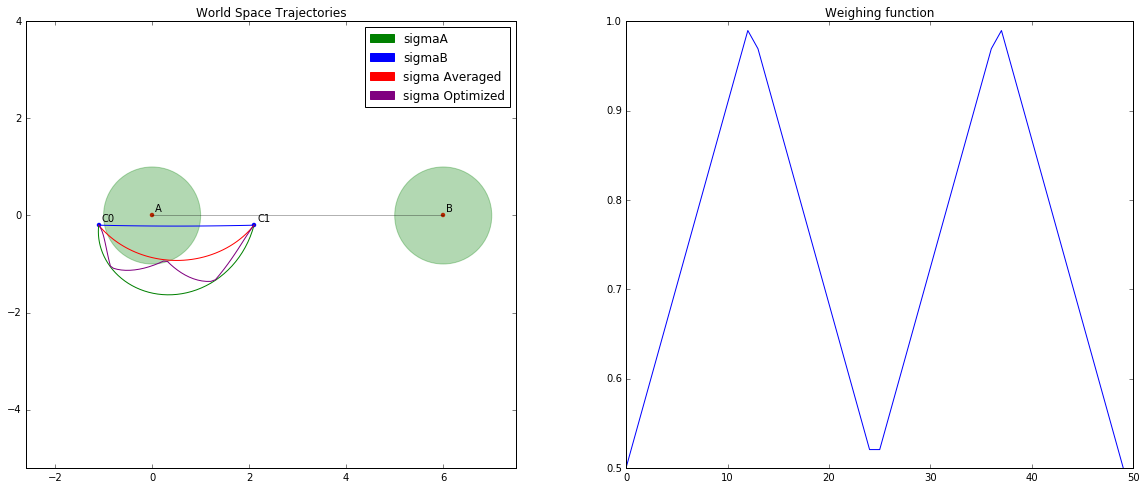

In [7]:
min_dist = 1                    # let's set a minimum distance of 1m
personA  = np.array([0,0,0])     # person A position
personB  = np.array([6,0,0])     # person B position
C0 = np.array([-1.1,-0.2,0])  # Starting camera position is *outside* of PA_1
C1 = np.array([2.1,-0.2,0])    # Ending camera position


sigmaA = None
sigmaB = None

def blendOptimizer_silly_extractor(u, sigma_i, sigma_j, i, j, d1, d2):
    global sigmaA
    global sigmaB
    
    sigmaA = sigma_i
    sigmaB = sigma_j
    
    f = interpolate.interp1d([0,0.25,0.5,0.75,1],[0.5,1,0.5,1,0.5])
    blend = f(u)
    sigmaBlended = (blend*sigma_i + (1-blend)*sigma_j)
    
    return (blend, sigmaBlended)

create_blended_trajectory(personA, personB, C0, C1, min_dist,blendOptimizer_silly_extractor)

# Test 6: All the Constraints with a partia jacobian!

A continuation of notebook 15.

 --> Initial xstate not provided; setting to 0
 --> Initial Fstate not provided; setting to 0
----------------------------------------------------------------------------------
 SNOPT python interface   (Feb 2015)
   Problem: blend_test3
   # variables = 300; # constraints = 351 

     Name state(j)      low(j)           x(j)           upp(j)        mul(j)
x:
        0       0    0.000000e+00    5.000000e-01    1.000000e+00    0.000000e+00
        1       0   -1.000000e+20    0.000000e+00    1.000000e+20    0.000000e+00
        2       0   -1.000000e+20    0.000000e+00    1.000000e+20    0.000000e+00
        3       0   -1.000000e+20    0.000000e+00    1.000000e+20    0.000000e+00
        4       0   -1.000000e+20    0.000000e+00    1.000000e+20    0.000000e+00
        5       0   -1.000000e-03    0.000000e+00    1.000000e-03    0.000000e+00
        6       0    0.000000e+00    5.000000e-01    1.000000e+00    0.000000e+00
        7       0   -1.000000e+20    0.000000e+00    1.000000e+2

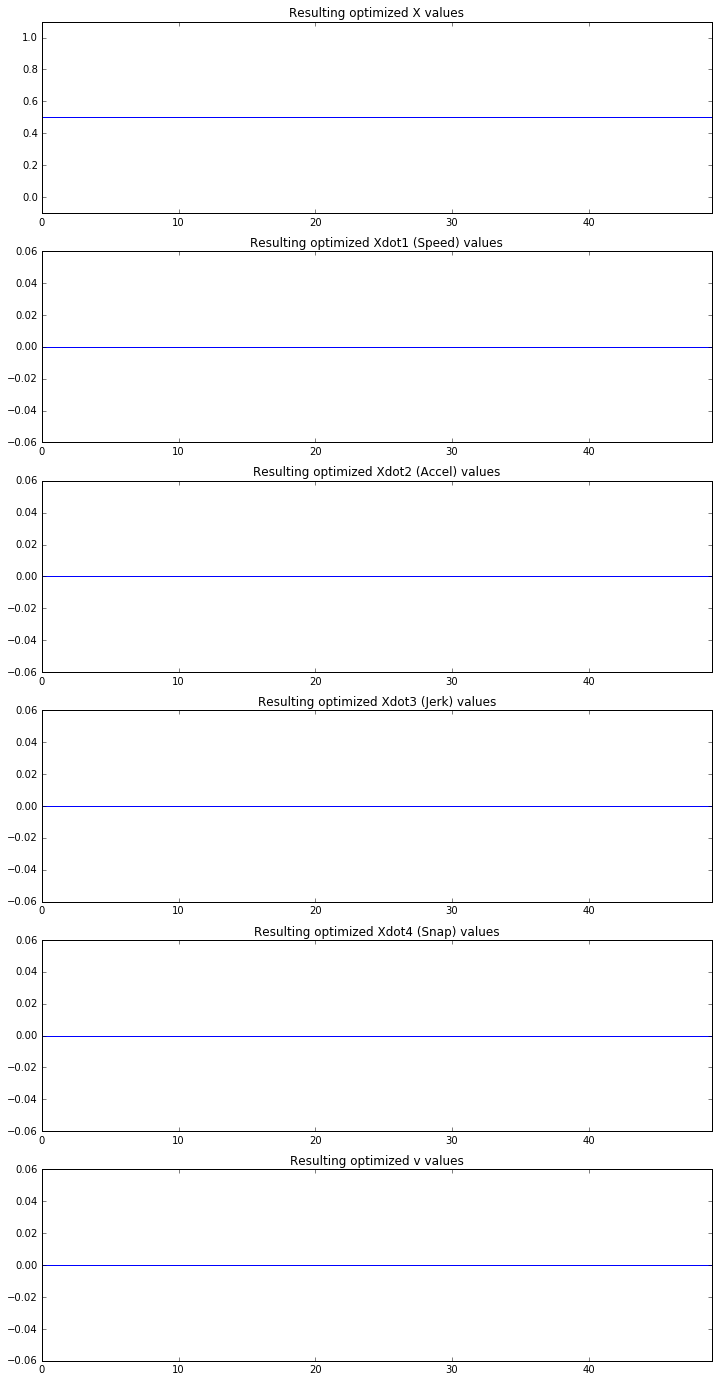

In [51]:
# This assumes a sigmaA and sigmaB variable, as well as an personA and personB, exists.

sigmaA = sigmaA
sigmaB = sigmaB
personA = personA
personB = personB
min_distA = min_dist
min_distB = min_dist

# Some important parameters here

nsamples = 50
ndims    = 6
nvars = ndims*nsamples
nconstraints_continuity = (ndims-1)*nsamples
nconstraints_obstacles = 2*nsamples
nconstraints = 1 + nconstraints_continuity + nconstraints_obstacles # 1 is for the objective
 

dt = 0.01
xdot5_limit = 0.001

inf = 1.0e20

lambda_snap = 1#(1/dt)**4 # snap must be scaled down to be comparable to position.
lambda_pos = 1

# NOTE: We have this stupid dummy value since snopt-python has a bug.


# Solver Time!

snopt = SNOPT_solver()
snopt.setOption('Verbose',True)
snopt.setOption('Solution print',False)
snopt.setOption('Print file','test6.out')
snopt.setOption('Iteration limit',8000)
snopt.setOption('Print level',3)
snopt.setOption('Major optimality',2e-6)

# 
# # snopt.setOption('Linesearch tolerance',0.4)
snopt.setOption('Verify level',3) # Turn to 3 to carefully check gradiants
# snopt.setOption('Print level',3)
# snopt.setOption('Major print level',0)

# 1. Set up decision variables

x     = np.array([0.5]*nsamples) # Initialize to 0.5
xdot1 = np.array([0.0]*nsamples)
xdot2 = np.array([0.0]*nsamples)
xdot3 = np.array([0.0]*nsamples)
xdot4 = np.array([0.0]*nsamples)
v     = np.array([0.0]*nsamples) # C4 Continuity Control Variable

x0 = np.matrix(np.c_[x,xdot1,xdot2,xdot3,xdot4,v]).A1 # Interleave [x[0],xdot1[0],xdot2[0]...]

# 2. Set up the bounds on x

low_x     = np.array([ 0.0] *nsamples) # X must be greater or equal to 0
low_xdot1 = np.array([ -inf]*nsamples)
low_xdot2 = np.array([ -inf]*nsamples)
low_xdot3 = np.array([ -inf]*nsamples)
low_xdot4 = np.array([ -inf]*nsamples)
low_v     = np.array([ -xdot5_limit]*nsamples) # Bound control variable arbitrarily

#low_x[0] = 0.5
#low_x[nsamples-1] = 0.5

xlow = np.matrix(np.c_[low_x,low_xdot1,low_xdot2,low_xdot3,low_xdot4,low_v]).A1 # Interleave [x[0],xdot1[0],xdot2[0]...]

upp_x     = np.array([ 1.0] *nsamples) # X must be greater or equal to 0
upp_xdot1 = np.array([ inf]*nsamples)
upp_xdot2 = np.array([ inf]*nsamples)
upp_xdot3 = np.array([ inf]*nsamples)
upp_xdot4 = np.array([ inf]*nsamples)
upp_v     = np.array([ xdot5_limit]*nsamples) # Bound control variable arbitrarily

#upp_x[0] = 0.5
#upp_x[nsamples-1] = 0.5

xupp = np.matrix(np.c_[upp_x,upp_xdot1,upp_xdot2,upp_xdot3,upp_xdot4,upp_v]).A1 # Interleave [x[0],xdot1[0],xdot2[0]...]

# 3. Set up the objective function

M = np.array([
        [0,1,0,0,0],
        [0,0,1,0,0],
        [0,0,0,1,0],
        [0,0,0,0,1],
        [0,0,0,0,0]
    ])

N = np.array([0,0,0,0,1])

def grad_function(xM, compute_nonzero_only=False, compute_linear=False):
    # G[row, col]
    # Where each column is a partial derivative with respect to a single variable x_i
    G = np.zeros((nconstraints, nvars))
    obj_col = G[0,:]

    # Set up the jacobian structure of the cost function. 
    # This only impacts the w_i and wdot4_i variables 
    if not compute_nonzero_only:
        obj_col[::6] = 2*dt*lambda_pos*(xM[:,0] - 0.5)
        obj_col[4::6] = 2*dt*lambda_snap*xM[:,4]
    elif not compute_linear:
        obj_col[::6] = 1
        obj_col[4::6] = 1        

    if compute_nonzero_only:
        for fi in range(nconstraints_continuity+1, nconstraints_continuity+nconstraints_obstacles):
            G[fi,:] = 1
            
    if compute_linear:
        
        stupidcounter = 0
        add_to_fi = 0    
        for fi in range(1,nconstraints_continuity-5): # Looping over the objective function
            fi_row = G[fi,:]

            fi += add_to_fi

            fi_row[fi-1] = 1
            fi_row[fi]   = dt
            fi_row[fi+5] = -1

            stupidcounter += 1
            if stupidcounter == 5:
                add_to_fi += 1
                stupidcounter = 0
            
    return G    

def calc_obj(xM):
    # our objective is the sum of
    # the L2 norm of our position error away from 0.5
    # the L2 norm of our 4th derivative error away from 0
    obj_pos  = dt * np.sum( (xM[:,0] - 0.5)**2)
    obj_snap = dt * np.sum( (xM[:,4]      )**2)  
    objective = lambda_pos * obj_pos + lambda_snap * obj_snap
    return (objective, obj_pos, obj_snap)

cA = None
cB = None

def calc_obstacle_constraints(xM):
    
    global cA
    global cB
    
    blend = xM[:,0]
    
    sigmaBlended = (blend[:,np.newaxis]*sigmaA + (1-blend)[:,np.newaxis]*sigmaB)
    constraintA = la.norm(sigmaBlended - personA, axis=1) - min_distA
    constraintB = la.norm(sigmaBlended - personB, axis=1) - min_distB
    
    cA = constraintA
    cB = constraintB
    return np.r_[cA, cB]
    

def blend_test3_objFG(status,x,needF,needG,cu,iu,ru):

    xM = x.reshape(nsamples,ndims)
    
    objective, obj_pos, obj_snap = calc_obj(xM)

    # Evaluate the current continuity constraints
    continuity_x = np.zeros((nsamples, 5))

    for i in range(nsamples-1):
        si  = xM[i,0:5]
        vi  = xM[i,5  ]
        si1 = xM[i+1,0:5]
        continuity_x[i] = si + (M.dot(si) + N.dot(vi))*dt - si1
   
    continuity_x = np.matrix(continuity_x).A1
    
    obstacles = calc_obstacle_constraints(xM)
    
    F = np.concatenate(
        ([objective],
         continuity_x,
         obstacles))
        
    G = grad_function(xM)
    
    return status, F, G[G_nonzero_inds]

# 4. Set up bounds on F
# [ objectivec can be anything, equal-to-zero for continuity, greater-than-0 for obstacles along traj]
low_F    = np.concatenate(([-inf], np.array([0,0,0,0,0]*nsamples), [0  , 0]*nsamples))
upp_F    = np.concatenate(([ inf], np.array([0,0,0,0,0]*nsamples), [inf, inf]*nsamples))

# Matrix uses fortran numbering or something
ObjRow = 1

# Set up the linear and nonlinear structure of the jacobian matrix

xM = x0.reshape(nsamples,ndims)

G = grad_function(xM,compute_nonzero_only=True, compute_linear=False)
G_nonzero_inds           = G.nonzero()

A = grad_function(xM,compute_nonzero_only=True, compute_linear=True)


# We first solve the problem without providing derivative info
a = time.time()

snopt.snopta(name='blend_test3',usrfun=blend_test3_objFG,x0=x0,xlow=xlow,xupp=xupp,
             Flow=low_F,Fupp=upp_F,ObjRow=ObjRow,A=A,G=G)
b = time.time()

print "Solved in %.4fs" % (b - a)

print "Value of objective function: %.8f" % snopt.F[0]

pylab.rcParams['figure.figsize'] = 12, 24
gs = gridspec.GridSpec(6, 1, width_ratios=[1], height_ratios=[1,1,1,1,1,1]) 
fig = plt.figure()
f1 = fig.add_subplot(gs[0])
f2 = fig.add_subplot(gs[1])
f3 = fig.add_subplot(gs[2])
f4 = fig.add_subplot(gs[3])
f5 = fig.add_subplot(gs[4])
f6 = fig.add_subplot(gs[5])

f1.plot(snopt.x[0::6])
f1.set_ylim([-.1,1.1])
f1.set_xlim([0,nsamples-1])
f1.set_title("Resulting optimized X values")

f2.plot(snopt.x[1::6])
f2.set_ylim()
f2.set_xlim([0,nsamples-1])
f2.set_title("Resulting optimized Xdot1 (Speed) values")

f3.plot(snopt.x[2::6])
f3.set_ylim()
f3.set_xlim([0,nsamples-1])
f3.set_title("Resulting optimized Xdot2 (Accel) values")

f4.plot(snopt.x[3::6])
f4.set_ylim()
f4.set_xlim([0,nsamples-1])
f4.set_title("Resulting optimized Xdot3 (Jerk) values")

f5.plot(snopt.x[4::6])
f5.set_ylim()
f5.set_xlim([0,nsamples-1])
f5.set_title("Resulting optimized Xdot4 (Snap) values")

f6.plot(snopt.x[5::6])
f6.set_ylim()
f6.set_xlim([0,nsamples-1])
f6.set_title("Resulting optimized v values")

xM = snopt.x.reshape(nsamples,ndims)

print " lambda_pos: %f, lambda_snap: %f, " % (lambda_pos, lambda_snap)
print " objective: %f, obj_pos: %f, obj_snap: %f" % calc_obj(xM)


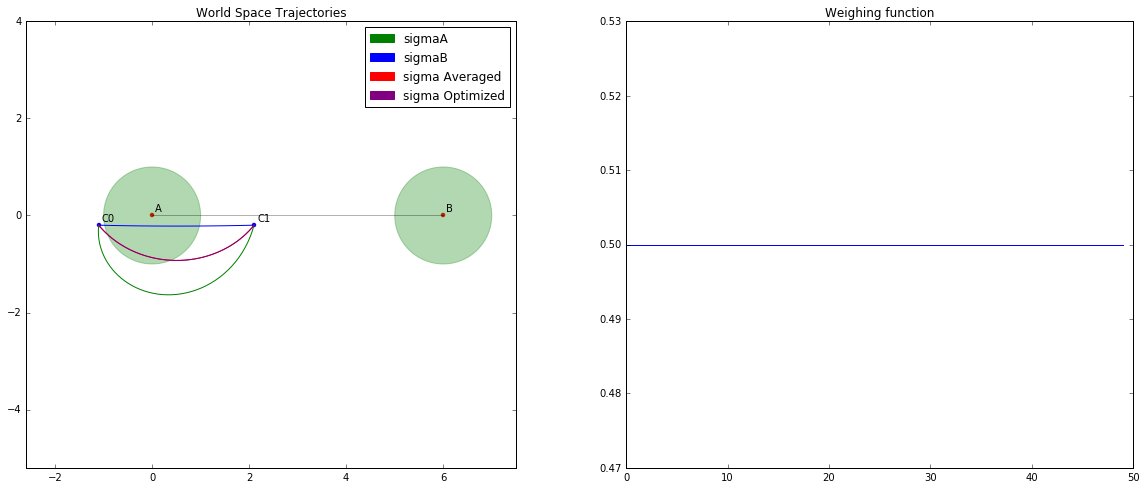

In [42]:
xM = snopt.x.reshape(nsamples,ndims)

def blendOptimizer_silly_injector(u, sigma_i, sigma_j, i, j, d1, d2):
    blend = xM[:,0]
    sigmaBlended = (blend[:,np.newaxis]*sigmaA + (1-blend)[:,np.newaxis]*sigmaB)
    
    return (blend, sigmaBlended)

create_blended_trajectory(personA, personB, C0, C1, min_dist,blendOptimizer_silly_injector)

# Turn the optimizer into a function called from our trajectory planner

## Time to generate a bunch of example trajectories!

In [154]:

def test4_optimize_blending_function(sigmaA, sigmaB, personA, personB, min_distA, min_distB, constrain_at_endpoints=False):
    # Some important parameters here
    nsamples = 50
    ndims    = 6
    
    dt = 0.01
    xdot5_limit = 0.001

    inf = 1.0e20

    lambda_snap = 1#(1/dt)**4 # snap must be scaled down to be comparable to position.
    lambda_pos = 1

    # A few derived quantities
    nvars = ndims*nsamples
    nconstraints_continuity = (ndims-1)*nsamples
    nconstraints_obstacles = 2*nsamples
    nconstraints = 1 + nconstraints_continuity + nconstraints_obstacles

    # Solver configuration
    snopt = SNOPT_solver()
    snopt.setOption('Verbose',False)
    snopt.setOption('Solution print',False)
    snopt.setOption('Print file','test4.out')
    snopt.setOption('Iteration limit',8000)
    snopt.setOption('Print level',3)
    snopt.setOption('Major optimality',2e-6)
    snopt.setOption('Verify level',3) # Turn to 3 to carefully check gradiants


    # 1. Set up decision variables
    x     = np.array([0.5]*nsamples) # Initialize to 0.5
    xdot1 = np.array([0.0]*nsamples)
    xdot2 = np.array([0.0]*nsamples)
    xdot3 = np.array([0.0]*nsamples)
    xdot4 = np.array([0.0]*nsamples)
    v     = np.array([0.0]*nsamples) # C4 Continuity Control Variable

    x0 = np.matrix(np.c_[x,xdot1,xdot2,xdot3,xdot4,v]).A1 # Interleave [x[0],xdot1[0],xdot2[0]...]

    # 2. Set up the bounds on x
    low_x     = np.array([ 0.0] *nsamples) # X must be greater or equal to 0
    low_xdot1 = np.array([ -inf]*nsamples)
    low_xdot2 = np.array([ -inf]*nsamples)
    low_xdot3 = np.array([ -inf]*nsamples)
    low_xdot4 = np.array([ -inf]*nsamples)
    low_v     = np.array([ -xdot5_limit]*nsamples) # Bound control variable arbitrarily
    if constrain_at_endpoints:
        low_x[0] = 0.5
        low_x[nsamples-1] = 0.5    
    xlow = np.matrix(np.c_[low_x,low_xdot1,low_xdot2,low_xdot3,low_xdot4,low_v]).A1 # Interleave [x[0],xdot1[0],xdot2[0]...]

    upp_x     = np.array([ 1.0] *nsamples) # X must be greater or equal to 0
    upp_xdot1 = np.array([ inf]*nsamples)
    upp_xdot2 = np.array([ inf]*nsamples)
    upp_xdot3 = np.array([ inf]*nsamples)
    upp_xdot4 = np.array([ inf]*nsamples)
    upp_v     = np.array([ xdot5_limit]*nsamples) # Bound control variable arbitrarily
    if constrain_at_endpoints:
        upp_x[0] = 0.5
        upp_x[nsamples-1] = 0.5
    xupp = np.matrix(np.c_[upp_x,upp_xdot1,upp_xdot2,upp_xdot3,upp_xdot4,upp_v]).A1 # Interleave [x[0],xdot1[0],xdot2[0]...]

    # 3. Set up the objective function
    M = np.array([
            [0,1,0,0,0],
            [0,0,1,0,0],
            [0,0,0,1,0],
            [0,0,0,0,1],
            [0,0,0,0,0]
        ])

    N = np.array([0,0,0,0,1])

    def grad_function(xM, compute_nonzero_only=False, compute_linear=False):
        G = np.zeros((nconstraints, nvars))

        # Set up the jacobian structure of the cost function. 
        # This only impacts the w_i and wdot4_i variables 
        obj_col = G[0,:]
        if not compute_nonzero_only:
            obj_col[::6] = 2*dt*lambda_pos*(xM[:,0] - 0.5)
            obj_col[4::6] = 2*dt*lambda_snap*xM[:,4]
        elif not compute_linear:
            obj_col[::6] = 1
            obj_col[4::6] = 1        

        if compute_linear:
            # The C4 continuity constraint is linear
            stupidcounter = 0
            add_to_fi = 0    
            for fi in range(1,nconstraints_continuity-5): # Looping over the objective function
                fi_row = G[fi,:]

                fi += add_to_fi

                fi_row[fi-1] = 1
                fi_row[fi]   = dt
                fi_row[fi+5] = -1

                stupidcounter += 1
                if stupidcounter == 5:
                    add_to_fi += 1
                    stupidcounter = 0

        return G    

    def calc_obj(xM):
        # our objective is the sum of
        # the L2 norm of our position error away from 0.5
        # the L2 norm of our 4th derivative error away from 0
        obj_pos  = dt * np.sum( (xM[:,0] - 0.5)**2)
        obj_snap = dt * np.sum( (xM[:,4]      )**2)  
        objective = lambda_pos * obj_pos + lambda_snap * obj_snap
        return (objective, obj_pos, obj_snap)

    def calc_obstacle_constraints(xM):
        blend = xM[:,0]
        sigmaBlended = (blend[:,np.newaxis]*sigmaA + (1-blend)[:,np.newaxis]*sigmaB)
        constraintA = la.norm(sigmaBlended - personA, axis=1) - min_distA
        constraintB = la.norm(sigmaBlended - personB, axis=1) - min_distB
        return np.r_[constraintA, constraintB]

    def blend_test3_objFG(status,x,needF,needG,cu,iu,ru):

        xM = x.reshape(nsamples,ndims)

        objective, obj_pos, obj_snap = calc_obj(xM)

        # Evaluate the current continuity constraints
        continuity_x = np.zeros((nsamples, 5))
        for i in range(nsamples-1):
            si  = xM[i,0:5]
            vi  = xM[i,5  ]
            si1 = xM[i+1,0:5]
            continuity_x[i] = si + (M.dot(si) + N.dot(vi))*dt - si1
        continuity_x = np.matrix(continuity_x).A1

        obstacles = calc_obstacle_constraints(xM)

        F = np.concatenate(
            ([objective],
             continuity_x,
             obstacles))

        G = grad_function(xM)

        return status, F#, G[G_nonzero_inds]

    # 4. Set up bounds on F
    # [ objectivec can be anything, equal-to-zero for continuity, greater-than-0 for obstacles along traj]
    low_F    = np.concatenate(([-inf], np.array([0,0,0,0,0]*nsamples), [0  , 0]*nsamples))
    upp_F    = np.concatenate(([ inf], np.array([0,0,0,0,0]*nsamples), [inf, inf]*nsamples))

    # Matrix uses fortran numbering or something
    ObjRow = 1

    # Set up the linear and nonlinear structure of the jacobian matrix
    xM = x0.reshape(nsamples,ndims)
    G = grad_function(xM,compute_nonzero_only=True, compute_linear=False)
    G_nonzero_inds           = G.nonzero()
    A = grad_function(xM,compute_nonzero_only=True, compute_linear=True)

    # Now we solve
    a = time.time()

    snopt.snopta(name='blend_test3',usrfun=blend_test3_objFG,x0=x0,xlow=xlow,xupp=xupp,
                 Flow=low_F,Fupp=upp_F,ObjRow=ObjRow)
    b = time.time()

    print "Solved in %.4fs" % (b - a)

    print "Value of objective function: %.8f" % snopt.F[0]
    print "   lambda_pos: %f, lambda_snap: %f, " % (lambda_pos, lambda_snap)
    print "   objective: %f, obj_pos: %f, obj_snap: %f" % calc_obj(xM)
    
    xM = snopt.x.reshape(nsamples, ndims)
    return (xM, snopt)


  Could not determine Jacobian structure from user input
  Calling snJac...
Solved in 1.0085s
Value of objective function: 0.00316127
   lambda_pos: 1.000000, lambda_snap: 1.000000, 
   objective: 0.000000, obj_pos: 0.000000, obj_snap: 0.000000


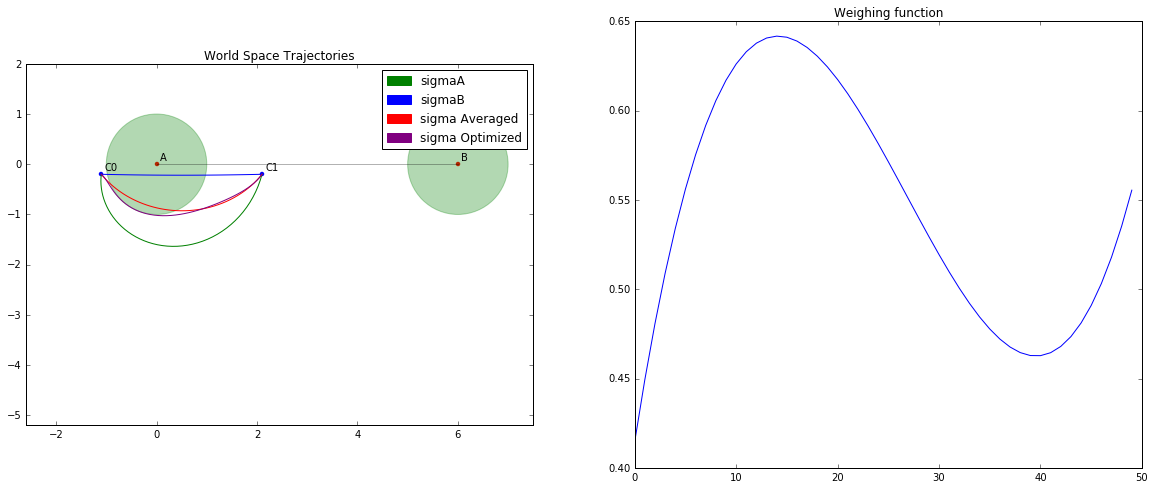

In [155]:

min_dist = 1                    # let's set a minimum distance of 1m
personA  = np.array([0,0,0])     # person A position
personB  = np.array([6,0,0])     # person B position
C0 = np.array([-1.1,-0.2,0])  # Starting camera position is *outside* of PA_1
C1 = np.array([2.1,-0.2,0])    # Ending camera position


def real_optimizer_unconstrained_at_endpoints(u, sigma_i, sigma_j, i, j, min_dist_i, min_dist_j):

    xM, snopt = test4_optimize_blending_function(sigma_i, sigma_j, i, j, min_dist_i, min_dist_j, constrain_at_endpoints=False)
    blend = xM[:,0]
    sigmaBlended = (blend[:,np.newaxis]*sigma_i + (1-blend)[:,np.newaxis]*sigma_j)
    
    return (blend, sigmaBlended)

def real_optimizer_constrained_at_endpoints(u, sigma_i, sigma_j, i, j, min_dist_i, min_dist_j):

    xM, snopt = test4_optimize_blending_function(sigma_i, sigma_j, i, j, min_dist_i, min_dist_j, constrain_at_endpoints=True)
    blend = xM[:,0]
    sigmaBlended = (blend[:,np.newaxis]*sigma_i + (1-blend)[:,np.newaxis]*sigma_j)
    
    return (blend, sigmaBlended)

create_blended_trajectory(personA, personB, C0, C1, min_dist,real_optimizer_unconstrained_at_endpoints)

  Could not determine Jacobian structure from user input
  Calling snJac...
Solved in 0.9701s
Value of objective function: 0.00353127
   lambda_pos: 1.000000, lambda_snap: 1.000000, 
   objective: 0.000000, obj_pos: 0.000000, obj_snap: 0.000000


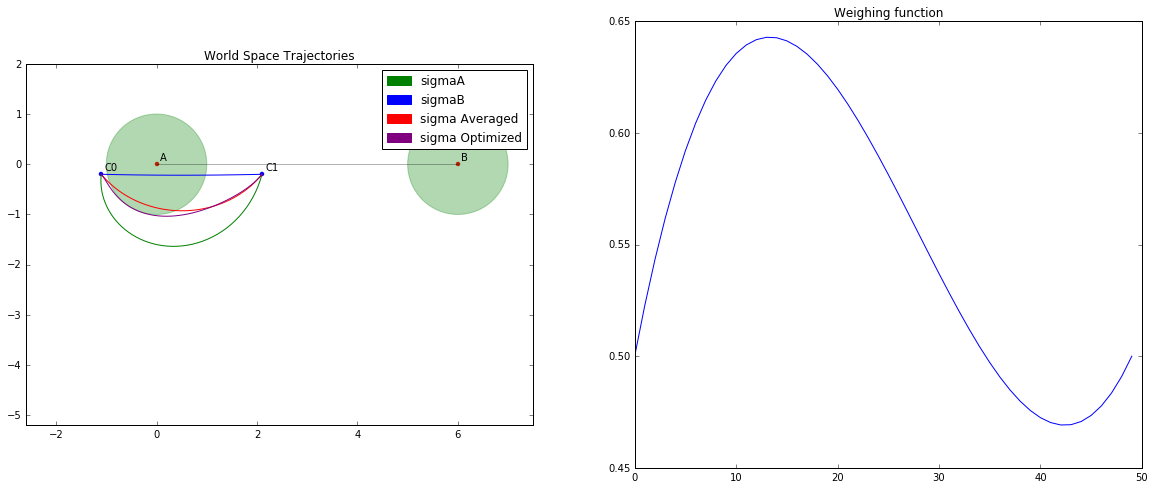

In [156]:
create_blended_trajectory(personA, personB, C0, C1, min_dist,real_optimizer_constrained_at_endpoints)

  Could not determine Jacobian structure from user input
  Calling snJac...
Solved in 1.0474s
Value of objective function: 0.04217752
   lambda_pos: 1.000000, lambda_snap: 1.000000, 
   objective: 0.000000, obj_pos: 0.000000, obj_snap: 0.000000


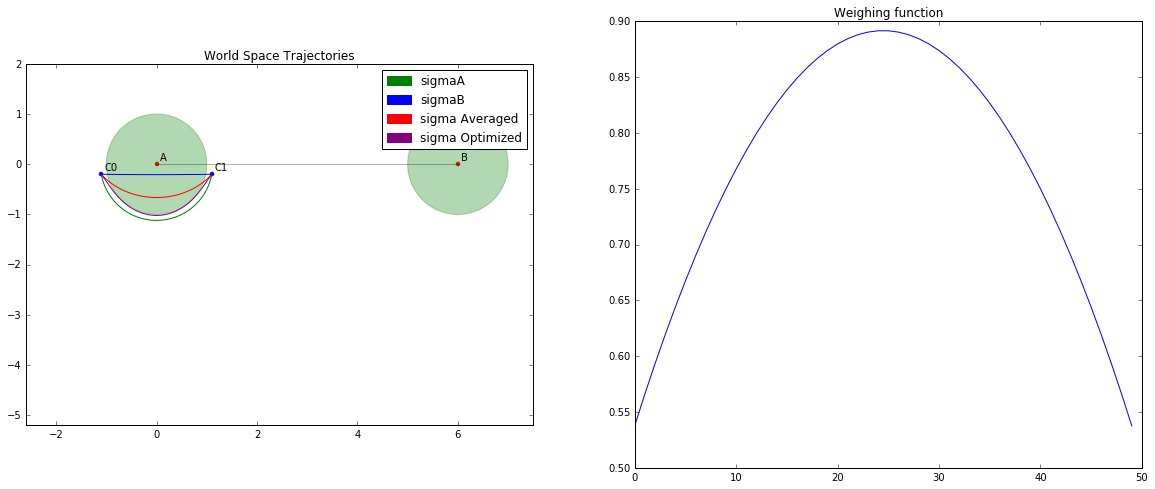

In [157]:
min_dist = 1                    # let's set a minimum distance of 1m
personA  = np.array([0,0,0])     # person A position
personB  = np.array([6,0,0])     # person B position
C0 = np.array([-1.1,-0.2,0])  # Starting camera position is *outside* of PA_1
C1 = np.array([1.1,-0.2,0])    # Ending camera position

create_blended_trajectory(personA, personB, C0, C1, min_dist,real_optimizer_unconstrained_at_endpoints)

  Could not determine Jacobian structure from user input
  Calling snJac...
Solved in 0.9955s
Value of objective function: 0.00069875
   lambda_pos: 1.000000, lambda_snap: 1.000000, 
   objective: 0.000000, obj_pos: 0.000000, obj_snap: 0.000000


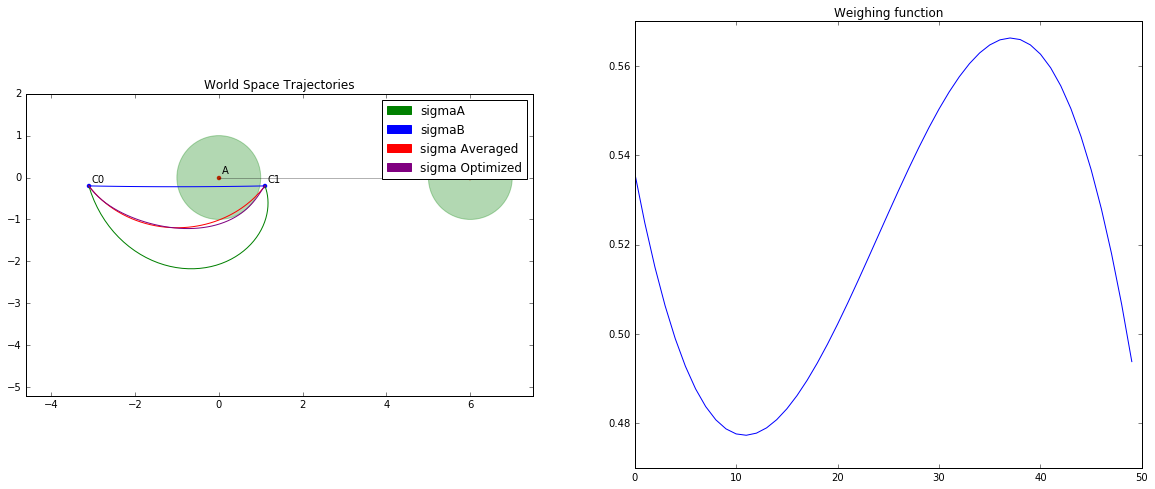

In [158]:
min_dist = 1                    # let's set a minimum distance of 1m
personA  = np.array([0,0,0])     # person A position
personB  = np.array([6,0,0])     # person B position
C0 = np.array([-3.1,-0.2,0])  # Starting camera position is *outside* of PA_1
C1 = np.array([1.1,-0.2,0])    # Ending camera position

create_blended_trajectory(personA, personB, C0, C1, min_dist,real_optimizer_unconstrained_at_endpoints)

  Could not determine Jacobian structure from user input
  Calling snJac...
Solved in 0.6739s
Value of objective function: 0.00000000
   lambda_pos: 1.000000, lambda_snap: 1.000000, 
   objective: 0.000000, obj_pos: 0.000000, obj_snap: 0.000000


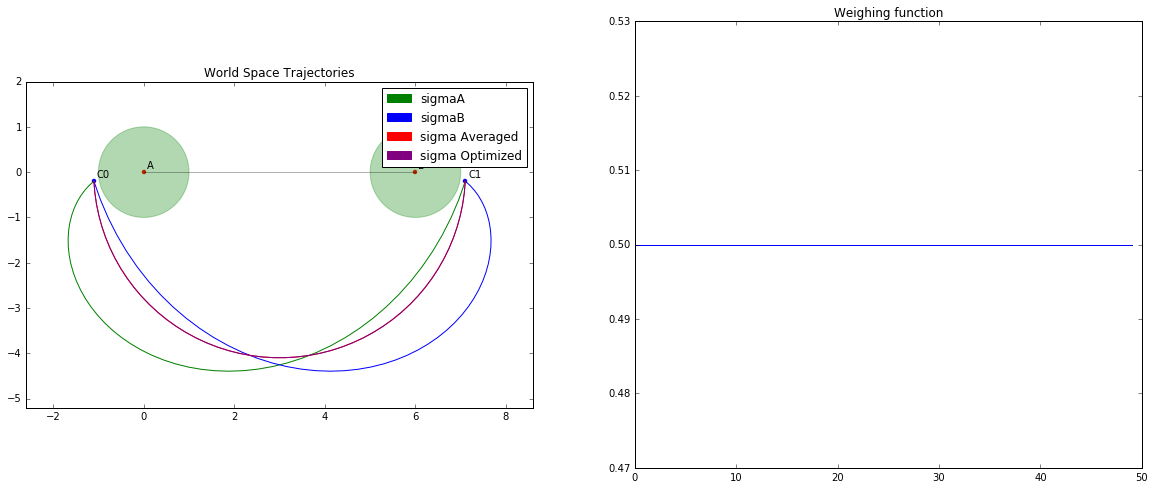

In [159]:
min_dist = 1                    # let's set a minimum distance of 1m
personA  = np.array([0,0,0])     # person A position
personB  = np.array([6,0,0])     # person B position
C0 = np.array([-1.1,-0.2,0])  # Starting camera position is *outside* of PA_1
C1 = np.array([7.1,-0.2,0])    # Ending camera position

create_blended_trajectory(personA, personB, C0, C1, min_dist,real_optimizer_unconstrained_at_endpoints)

  Could not determine Jacobian structure from user input
  Calling snJac...
Solved in 1.0124s
Value of objective function: 0.00612005
   lambda_pos: 1.000000, lambda_snap: 1.000000, 
   objective: 0.000000, obj_pos: 0.000000, obj_snap: 0.000000


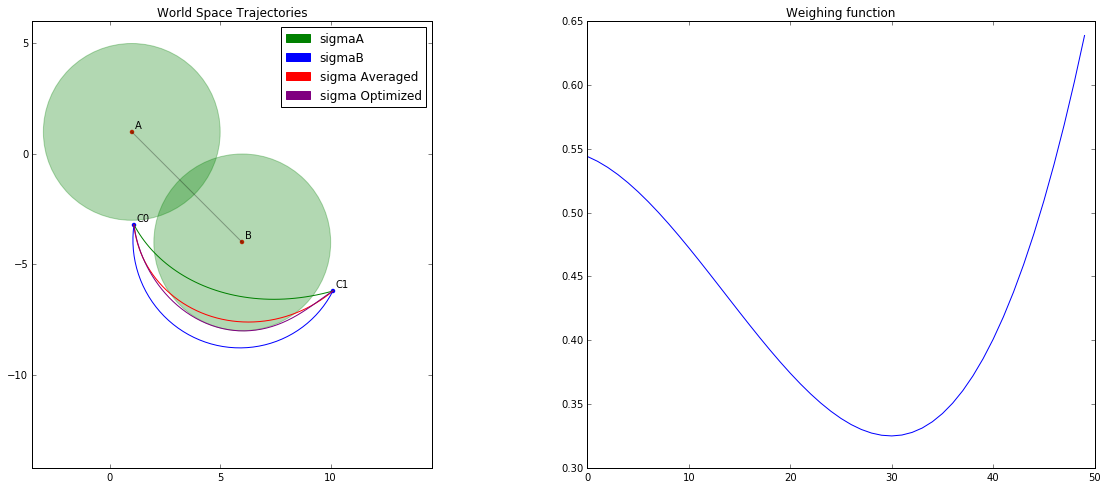

In [160]:
min_dist = 4                    # let's set a minimum distance of 1m
personA  = np.array([1,1,0])     # person A position
personB  = np.array([6,-4,0])     # person B position
C0 = np.array([1.1,-3.2,0])  # Starting camera position is *outside* of PA_1
C1 = np.array([10.1,-6.2,0])    # Ending camera position

create_blended_trajectory(personA, personB, C0, C1, min_dist,real_optimizer_unconstrained_at_endpoints)

  Could not determine Jacobian structure from user input
  Calling snJac...
Solved in 1.0909s
Value of objective function: 0.02682338
   lambda_pos: 1.000000, lambda_snap: 1.000000, 
   objective: 0.000000, obj_pos: 0.000000, obj_snap: 0.000000


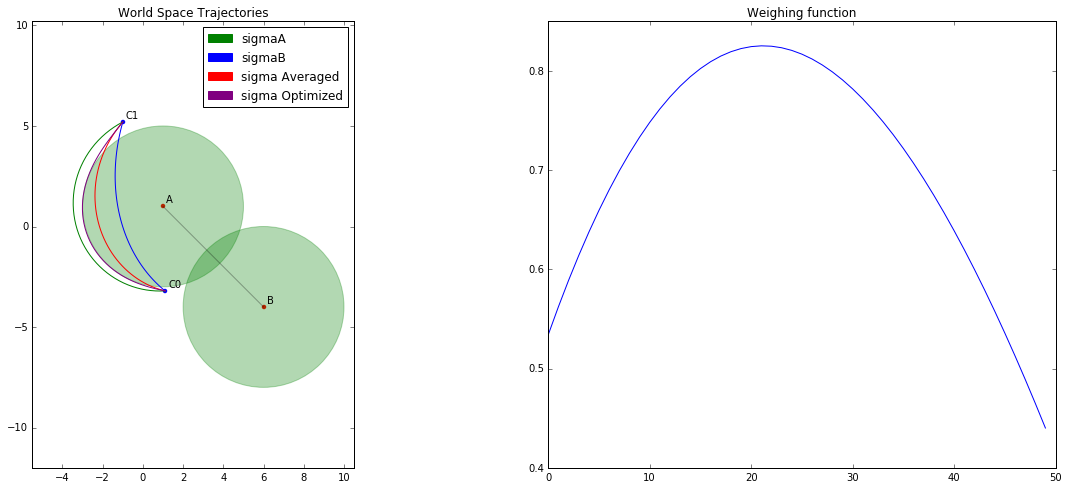

In [161]:
min_dist = 4                    # let's set a minimum distance of 1m
personA  = np.array([1,1,0])     # person A position
personB  = np.array([6,-4,0])     # person B position
C0 = np.array([1.1,-3.2,0])  # Starting camera position is *outside* of PA_1
C1 = np.array([-1,5.2,0])    # Ending camera position

create_blended_trajectory(personA, personB, C0, C1, min_dist,real_optimizer_unconstrained_at_endpoints)

  Could not determine Jacobian structure from user input
  Calling snJac...
Solved in 0.6540s
Value of objective function: 0.00000000
   lambda_pos: 1.000000, lambda_snap: 1.000000, 
   objective: 0.000000, obj_pos: 0.000000, obj_snap: 0.000000


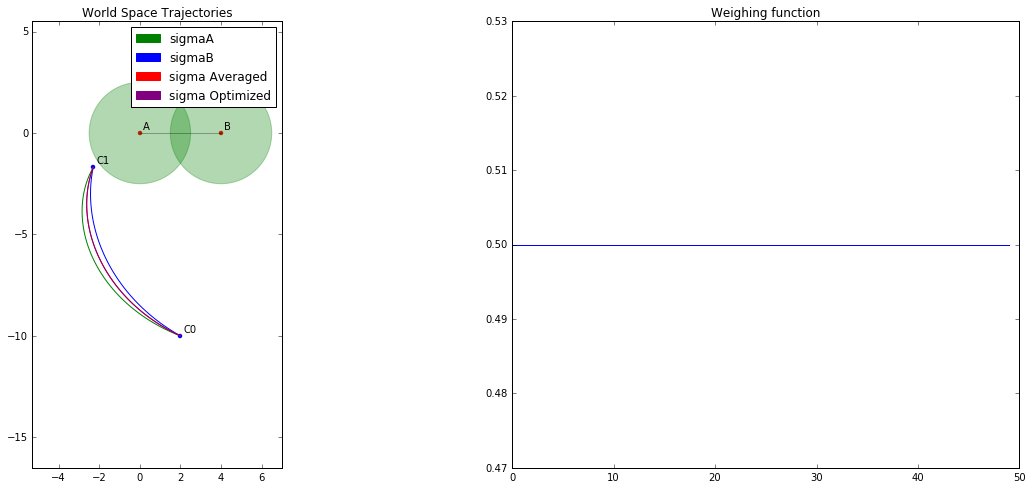

In [177]:
min_dist = 2.5                   # let's set a minimum distance of 1m
personA  = np.array([0,0,0])     # person A position
personB  = np.array([4,0,0])     # person B position
C0 = np.array([2,-10,0])  # Starting camera position is *outside* of PA_1
C1 = np.array([-2.3,-1.7,0])    # Ending camera position

create_blended_trajectory(personA, personB, C0, C1, min_dist,real_optimizer_unconstrained_at_endpoints)